# Clustering

In [16]:
library(data.table)

# Simulate school data (population)

We are going to use the `simstudy` package.

- 300 schools 
- Different number of classes
- Different number of students


In [2]:
library(simstudy)
set.seed(28112023)

# school level data
school = defData(
  varname = "school_effect", dist = "normal",
  formula = 2, variance = 0.5, id = "id_school"
)

school = defData(school,
  varname = "n_classes",
  dist = "noZeroPoisson", formula = 7
)

# generate date for 300 schools
dt_school = genData(300, school)

# class level data
class = defDataAdd(varname = "class_effect", dist = "normal", formula = 3, variance = 0.7)
class = defDataAdd(class, varname = "n_students", dist = "noZeroPoisson", formula = 20)

dt_class = genCluster(dt_school,
  cLevelVar = "id_school",
  numIndsVar = "n_classes", 
  level1ID = "id_class")

dt_class = addColumns(class, dt_class)

# student level data
student = defDataAdd(varname = "test", dist = "normal",
    formula = "50 + school_effect + class_effect", variance = 2)

student = defDataAdd(student, varname = "drug", dist = "binary",
    formula = "-6.5 + school_effect + class_effect", link="logit")

dt_student = genCluster(dt_class, cLevelVar = "id_class", 
    numIndsVar = "n_students",
    level1ID = "id_student")

dt_student = addColumns(student, dt_student)
dt_student[, n_schools := length(unique((id_school)))]
dt = list('school'=dt_school, 'class'=dt_class, 'student'=dt_student)
df = dt_student[, .(id_school, n_schools, id_class, id_student, test, drug)]

In [3]:
head(df)

id_school,n_schools,id_class,id_student,test,drug
<int>,<int>,<int>,<int>,<dbl>,<int>
1,300,1,1,55.14689,0
1,300,1,2,53.11693,0
1,300,1,3,54.02648,0
1,300,1,4,54.08705,0
1,300,1,5,57.01047,0
1,300,1,6,54.33926,0


In [5]:
# let's check the data and some schools
length(unique(df$id_school))
length(unique(df[id_school==300, id_class]))
length(unique(df[id_class==300, id_student]))

[1] 300

[1] 9

[1] 20

In [6]:
prop.table(table(df$drug))


        0         1 
0.7715699 0.2284301 

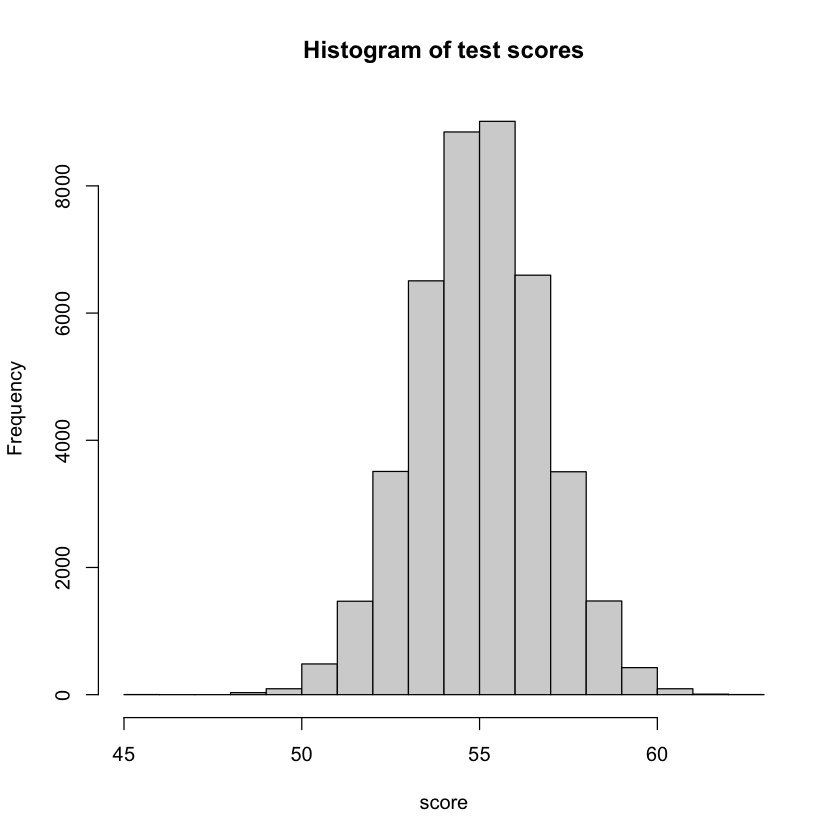

In [7]:
hist(df$test, main = "Histogram of test scores", xlab="score")

# Population intra-class correlation

In [18]:
library(lme4)
library(performance)

m0 = lmer(test ~ 1 + (1|id_school), data=df)
test_icc = performance::icc(m0, by_group=FALSE)$ICC_unadjusted
print(paste0('Test score ICC: ', round(test_icc, 3)))

[1] "Test score ICC: 0.197"


In [19]:
m1 = glmer(drug ~ 1 + (1|id_school), family='binomial', data=dt_student)
drug_icc = performance::icc(m1, by_group=FALSE)$ICC_unadjusted
print(paste0('Drug use ICC: ', round(drug_icc, 3)))

[1] "Drug use ICC: 0.137"


# Define first sample

In [11]:
# population of students
nrow(df)

[1] 42061

In [12]:
sample_schools = 50
sample_students = 10

cl = dt_school[sample(nrow(dt_school), size=sample_schools),][, .(id_school)]
print(paste0('Any duplicated schools?: ', anyDuplicated(cl$id_school)))

# selection probability
cl[, f1 := sample_schools/nrow(dt_school)]

df[, total_school_students := .N, by=id_school]
df[, total_students := .N]

# getting only students from selected schools
cl = merge(cl, df, by='id_school')
cl = cl[,.SD[sample(.N, min(sample_students, .N))], by = id_school]
print(paste0('Any duplicated student?: ', anyDuplicated(cl$id_student)))

cl[, f2 := .N/total_school_students, by=id_school]
cl[, w1 := 1/f1]
cl[, w2 := 1/f2]
cl[, weight := w1*w2]
tail(cl)

[1] "Any duplicated schools?: 0"
[1] "Any duplicated student?: 0"


id_school,f1,n_schools,id_class,id_student,test,drug,total_school_students,total_students,f2,w1,w2,weight
<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
300,0.1666667,300,2099,41895,56.40721,0,192,42061,0.05208333,6,19.2,115.2
300,0.1666667,300,2100,41922,54.63871,0,192,42061,0.05208333,6,19.2,115.2
300,0.1666667,300,2106,42045,54.74420,0,192,42061,0.05208333,6,19.2,115.2
300,0.1666667,300,2098,41892,53.97712,0,192,42061,0.05208333,6,19.2,115.2
300,0.1666667,300,2099,41903,55.76775,0,192,42061,0.05208333,6,19.2,115.2
300,0.1666667,300,2106,42053,55.02233,0,192,42061,0.05208333,6,19.2,115.2


In [13]:
summary(cl$weight)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   27.6    56.4    87.3    82.5   107.4   147.0 

In [15]:
# sum of weigths
round(sum(cl$weight)) 

# vs population size
nrow(dt_student)

[1] 41250

[1] 42061

# Define design using the `survey` package

In [21]:
library(survey)
d_cl_0 = svydesign(id = ~ 0, data=cl, fpc = ~total_students)
d_cl_1 = svydesign(id = ~ id_school, data = cl, probs = ~f1+f2, fpc =~n_schools)

In [22]:
mean(cl$drug)
weighted.mean(cl$drug, cl$weight)

[1] 0.196

[1] 0.2049018

## Naive estimation

In [24]:
svymean(~drug, design=d_cl_0, deff=TRUE)

         mean       SE DEff
drug 0.196000 0.017665    1

In [25]:
drug_estimate_0 = svymean(~drug, design = d_cl_0, deff=TRUE)
drug_ci_0 = confint(drug_estimate_0)
drug_moe_0 = as.vector(drug_ci_0 - drug_estimate_0[[1]])[2]

print(paste0('Drug use estimate: ', round(drug_estimate_0[1], 3)))
print(paste0('Drug use MOE ', round(drug_moe_0, 3)))

[1] "Drug use estimate: 0.196"
[1] "Drug use MOE 0.035"


## Estimation using sampling design

In [60]:
svymean(~drug, design = d_cl_1, deff=TRUE)

         mean       SE   DEff
drug 0.204902 0.024862 1.9164

In [61]:
drug_estimate_1 = svymean(~drug, design = d_cl_1, deff=TRUE)
drug_ci_1 = confint(drug_estimate_1)
drug_moe_1 = as.vector(drug_ci_1 - drug_estimate_1[[1]])[2]

print(paste0('Drug use estimate: ', round(drug_estimate_1[1], 3)))
print(paste0('Drug use MOE ', round(drug_moe_1, 3)))

[1] "Drug use estimate: 0.205"
[1] "Drug use MOE 0.049"


# Less schools, more students per school

In [71]:
sample_schools = 25
sample_students = 20
cl = dt_school[sample(nrow(dt_school), size=sample_schools),][, .(id_school)]

print(paste0('Any duplicated schools?: ', anyDuplicated(cl$id_school)))
cl[, f1 := sample_schools/nrow(dt_school)]
df[, total_school_students := .N, by=id_school]
df[, total_students := .N]

cl = merge(cl, df, by='id_school')
cl = cl[,.SD[sample(.N, min(sample_students, .N))], by = id_school]
print(paste0('Any duplicated student?: ', anyDuplicated(cl$id_student)))

cl[, f2 := .N/total_school_students, by=id_school]
cl[, w1 := 1/f1]
cl[, w2 := 1/f2]
cl[, w := w1 * w2]
tail(cl)

[1] "Any duplicated schools?: 0"
[1] "Any duplicated student?: 0"


id_school,f1,n_schools,id_class,id_student,test,drug,total_school_students,total_students,f2,w1,w2,w
<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
286,0.08333333,300,1983,39624,54.84067,0,162,42061,0.1234568,12,8.1,97.2
286,0.08333333,300,1982,39616,54.93850,0,162,42061,0.1234568,12,8.1,97.2
286,0.08333333,300,1981,39592,52.43994,1,162,42061,0.1234568,12,8.1,97.2
286,0.08333333,300,1987,39725,53.02985,0,162,42061,0.1234568,12,8.1,97.2
286,0.08333333,300,1983,39632,58.20627,0,162,42061,0.1234568,12,8.1,97.2
286,0.08333333,300,1981,39603,51.45496,0,162,42061,0.1234568,12,8.1,97.2


In [75]:
mean(cl$drug)
weighted.mean(cl$drug, cl$w)

[1] 0.232

[1] 0.2436248

In [76]:
d_cl_2 = svydesign(id = ~ id_school, data = cl, probs = ~f1+f2, fpc = ~n_schools)
svymean(~drug, design = d_cl_2, deff=TRUE)

         mean       SE   DEff
drug 0.243625 0.028834 2.2771

In [77]:
drug_estimate_2 = svymean(~drug, design = d_cl_2, deff=TRUE)
drug_ci_2 = confint(drug_estimate_2)
drug_moe_2 = as.vector(drug_ci_2 - drug_estimate_2[[1]])[2]

print(paste0('Drug use estimate: ', round(drug_estimate_2[1], 3)))
print(paste0('Drug use MOE ', round(drug_moe_2, 3)))

[1] "Drug use estimate: 0.244"
[1] "Drug use MOE 0.057"


# PPS example

In [78]:
# example from groves' book
block = 1:9
size = c(20, 100, 50, 15, 18, 45, 20, 35, 12)
blocks = data.table(block, size)
blocks[, end := cumsum(size)]
blocks[, start := shift(end, fill=0)]
blocks = blocks[, .(block, size, start, end)]
blocks

block,size,start,end
<int>,<dbl>,<dbl>,<dbl>
1,20,0,20
2,100,20,120
3,50,120,170
4,15,170,185
5,18,185,203
6,45,203,248
7,20,248,268
8,35,268,303
9,12,303,315


In [79]:
svalues = c(39, 144, 249)
selected_blocks = sapply(svalues, function(x) {
   blocks[block == which(start < x & end >= x), block]

})

# _blocksblocks
sblocks = blocks[block %in% selected_blocks]

In [80]:
selected_blocks

[1] 2 3 7

In [81]:
sblocks

block,size,start,end
<int>,<dbl>,<dbl>,<dbl>
2,100,20,120
3,50,120,170
7,20,248,268


In [82]:
sblocks[, block_prob := (size * 3) / 315]
sblocks[, unit_prob := 7/size]
sblocks[, weight := 1/(block_prob * unit_prob)]
sblocks

block,size,start,end,block_prob,unit_prob,weight
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,100,20,120,0.9523810,0.07,15
3,50,120,170,0.4761905,0.14,15
7,20,248,268,0.1904762,0.35,15


## Alternative PPS selection

In [84]:
blocks[, pblock := size / sum(size)]
blocks

block,size,start,end,pblock
<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,20,0,20,0.06349206
2,100,20,120,0.31746032
3,50,120,170,0.15873016
4,15,170,185,0.04761905
5,18,185,203,0.05714286
6,45,203,248,0.14285714
7,20,248,268,0.06349206
8,35,268,303,0.11111111
9,12,303,315,0.03809524


In [85]:
sum(blocks$pblock)

[1] 1

In [86]:
sblocks = blocks[sample(.N, 3, prob=pblock)]
sblocks[, block_prob := 3 * pblock]
sblocks[, block_prob_alt := (size * 3)/315]
sblocks[, unit_prob := 7/size]
sblocks[, w := 1/(block_prob * unit_prob)]

In [52]:
sblocks

block,size,start,end,pblock,block_prob,block_prob_alt,unit_prob,w
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,45,203,248,0.1428571,0.4285714,0.4285714,0.1555556,15
2,100,20,120,0.3174603,0.9523810,0.9523810,0.0700000,15
3,50,120,170,0.1587302,0.4761905,0.4761905,0.1400000,15
